In [ ]:
from pathlib import Path

import anndata as ad
import hotspot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import petracer
import scanpy as sc
import scipy as sp
import scvi
import seaborn as sns
import squidpy as sq
import treedata as td
import geopandas as gpd
from matplotlib_scalebar.scalebar import ScaleBar

np.random.seed(42)

base_path, data_path, plots_path, results_path = petracer.config.get_paths("tumor_tracing")
petracer.config.set_theme()

%load_ext autoreload
%autoreload 2
from petracer.utils import save_plot

In [ ]:
from petracer.config import (  # noqa: E402
    colors,
    edit_palette,
    get_clade_palette,
    module_palette,
    phase_palette,
    subtype_abbr,
    subtype_palette,
)

In [ ]:
adata = td.read_h5ad(data_path / "M1_tumor_tracing.h5td")

In [143]:
adata.write(data_path / "M1_tumor_tracing.h5td")

In [106]:
section_tdata = adata[adata.obs["sample"].isin(["M1-2"]) & adata.obs["tumor"].isin(["1"])
                     ].copy()
section_tdata = section_tdata[~np.isnan(section_tdata.obsm['spatial']).any(axis=1)].copy()
sc.pp.calculate_qc_metrics(section_tdata,percent_top = None,log1p = False,inplace = True,layer = "counts")
section_tdata = section_tdata[:,section_tdata.var["mean_counts"] > .1].copy()

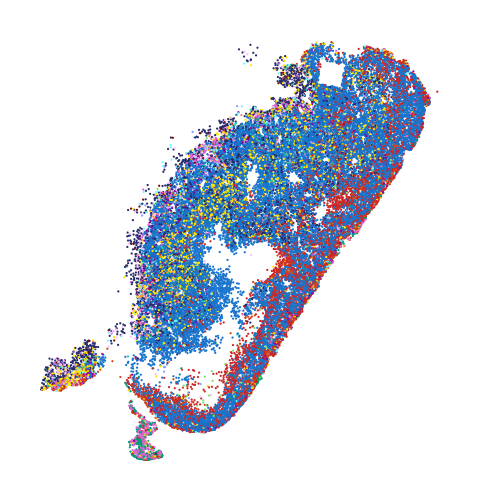

In [107]:
sc.pl.spatial(section_tdata,spot_size=20,color = "cell_subtype",legend_loc = "none"
              ,frameon=False,title = "")

In [108]:
hs = section_tdata.copy()
hs.X = hs.layers["counts"]
hs = hotspot.Hotspot(hs,latent_obsm_key="spatial", umi_counts_obs_key="total_counts",model = "normal")
hs.create_knn_graph(weighted_graph=False, n_neighbors=100)
hs_results = hs.compute_autocorrelations()

/lab/solexa_weissman/kyost/miniconda3/envs/petracer/lib/python3.11/site-packages/hotspot/hotspot.py:98: UserWarning: Hotspot will work faster when counts are a csr sparse matrix.
  warnings.warn(
100%|██████████| 60/60 [00:01<00:00, 38.60it/s]


In [109]:
hs_genes = hs_results.loc[hs_results.C > 0.04].index
local_correlations = hs.compute_local_correlations(hs_genes, jobs=4)

Computing pair-wise local correlation on 42 features...


100%|██████████| 861/861 [00:04<00:00, 185.35it/s]


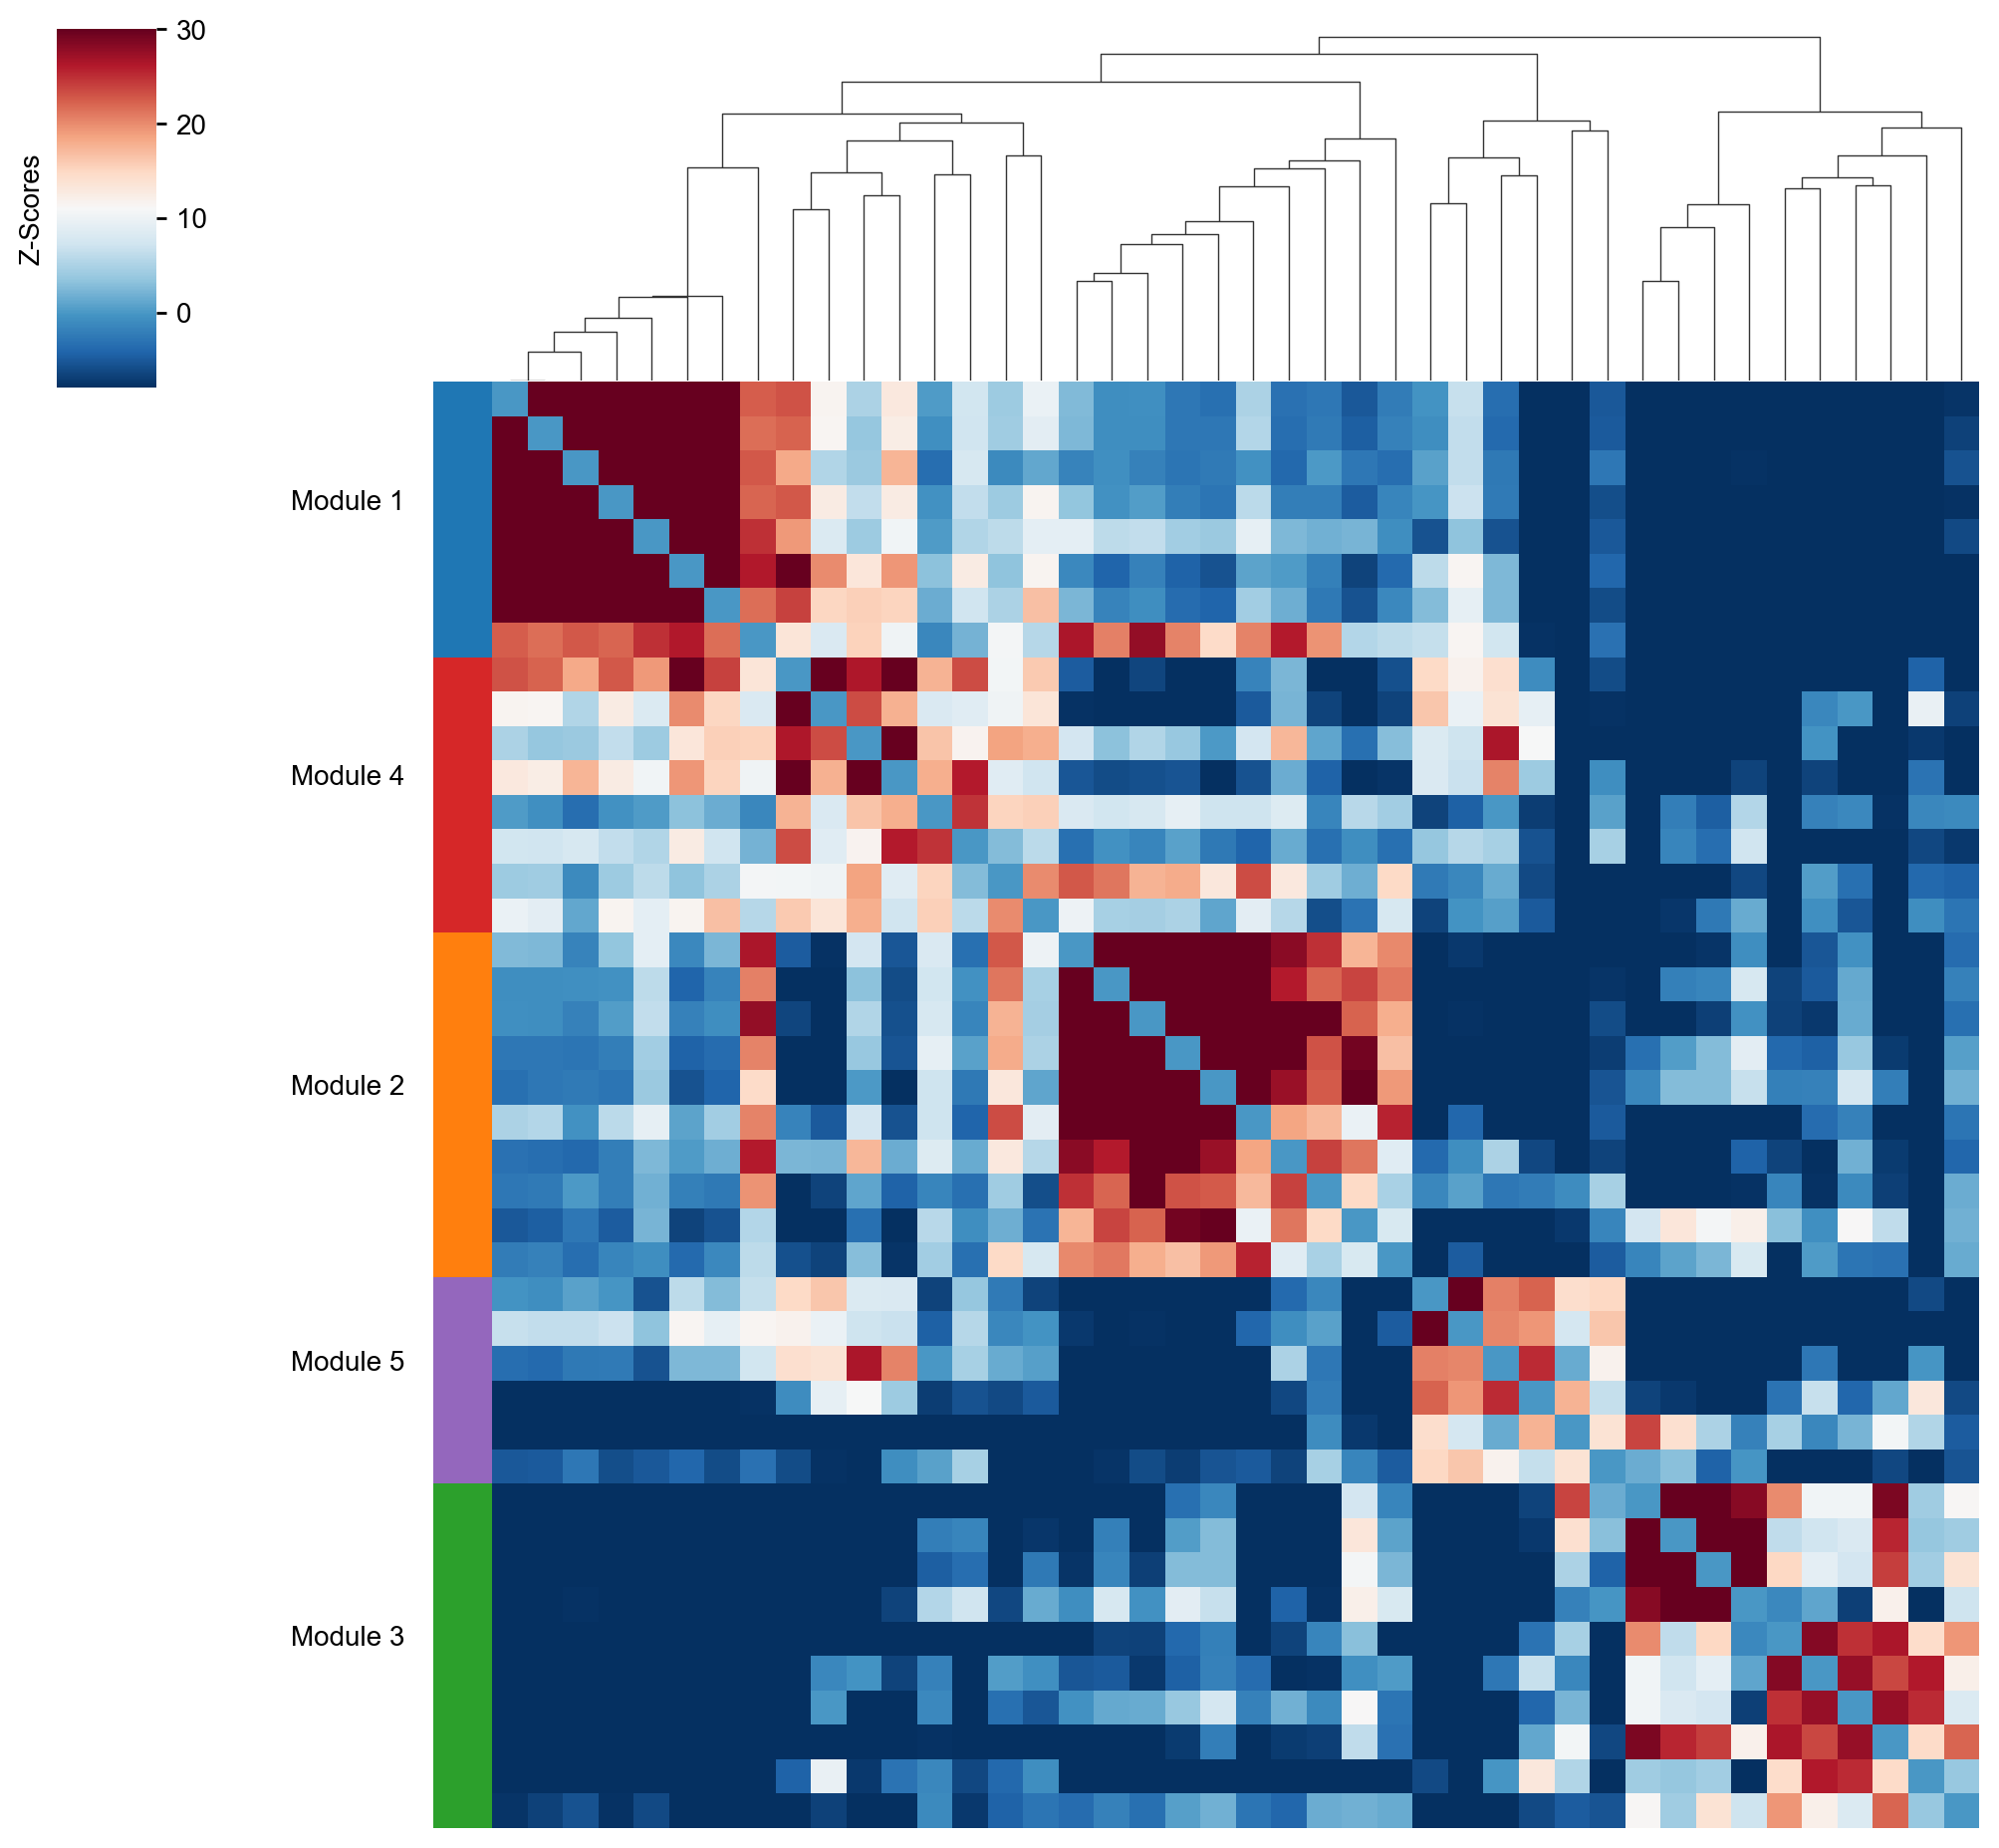

In [110]:
modules = hs.create_modules(min_gene_threshold=5, core_only=True, fdr_threshold=0.01)
hs.plot_local_correlations(vmax = 30)

In [132]:
modules

Cd22         1
Alox15       1
Cd79a        1
Wnt7b        3
Ighd         1
Pou2af1      1
Ebf1         1
Zbtb7b       3
Rassf4       1
Galnt18      2
Shank3       2
Sdc1         5
Arg1         5
Cldn4        3
Clec14a      2
Tmprss11e    3
Gata2        2
Chil1        2
Slc8a1       4
Camk4        3
Hoxa10       3
Cldn5        2
Ankrd1       3
Ldb2         2
Nes          3
Ptprb        2
Inava        3
Fscn1        3
Pld4         4
Plcb1        1
Dab2         5
Mmp12        5
C1qb         4
Ccr2         4
Gpr39        5
Slc7a2       5
Itgax        4
Gpihbp1      2
Flt3         4
Cxcl14       2
Itk          4
C1qc         4
Name: Module, dtype: int64

In [139]:
def hotspot_corr_heatmap(hs, plot_name,figsize = (4,4)):
    """Plot hotspot correlation heatmap."""
    # Load data
    hotspot_corr = hs.compute_local_correlations(hs_genes, jobs=4)
    hotsot_modules = hs.create_modules(min_gene_threshold=5, core_only=True, fdr_threshold=0.01)
    linkage = hs.linkage
    # Plot
    gene_color = hotsot_modules.astype(str).map(neighborhood_palette)
    g = sns.clustermap(hotspot_corr, cmap = "RdBu_r",center = 0,figsize = figsize,vmax = 30,vmin = -30,dendrogram_ratio=.05,
                col_linkage=linkage,row_linkage=linkage,col_colors = gene_color,row_colors=gene_color)
    y_ticks = hotspot_corr.index[g.dendrogram_row.reordered_ind]
    g.ax_heatmap.set_yticks(np.arange(len(y_ticks)) + .5)
    g.ax_heatmap.set_yticklabels(y_ticks, fontsize=6)  # Adjust 'fontsize' as needed
    g.ax_heatmap.set_xticklabels([])
    g.ax_heatmap.xaxis.set_ticks([])
    save_plot(g,plot_name,plots_path)

Computing pair-wise local correlation on 42 features...


100%|██████████| 861/861 [00:04<00:00, 194.87it/s]


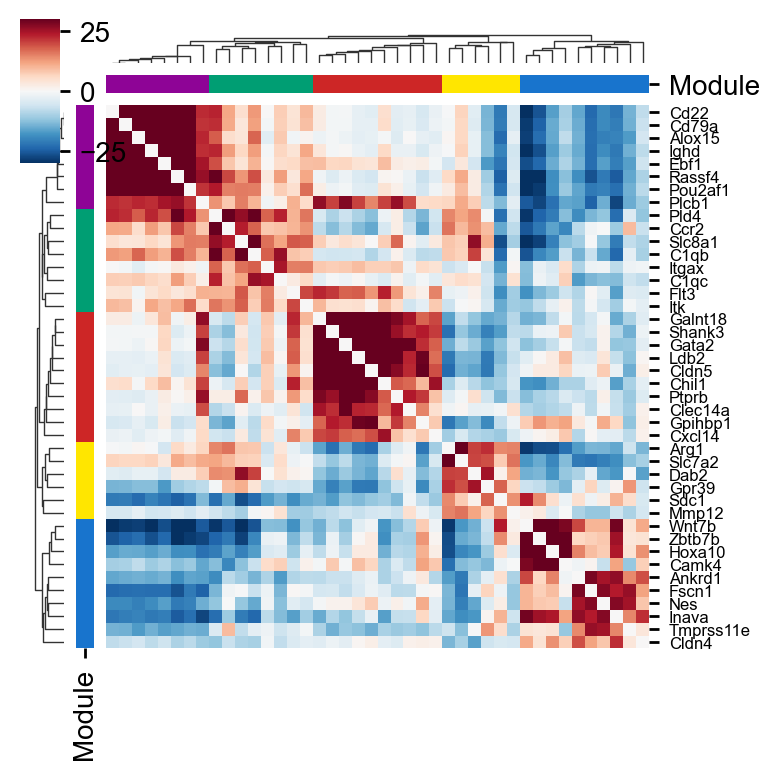

In [140]:
hotspot_corr_heatmap(hs, "cell_neighborhood_correlation_heatmap")

In [111]:
module_scores = hs.calculate_module_scores()
module_scores.columns = module_scores.columns.astype(str)
module = module_scores.idxmax(axis = 1).astype(str)

Computing scores for 5 modules...


100%|██████████| 5/5 [00:01<00:00,  4.74it/s]


In [112]:
section_tdata.obs["hotspot_module"] = module
section_tdata.obsm["module_scores"] = module_scores.reindex(section_tdata.obs_names)

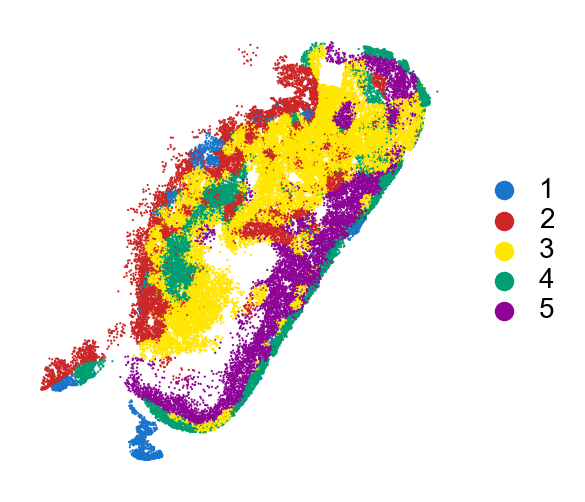

In [113]:
sc.pl.spatial(section_tdata,spot_size=20,color = "hotspot_module",frameon=False,title = "")

In [114]:
expr = sc.get.aggregate(section_tdata, by=["hotspot_module"], func=["mean"], layer = 'normalized')
expr = pd.DataFrame(sp.stats.zscore(expr.layers['mean'],axis = 0)
                    , index =expr.obs['hotspot_module'], columns=expr.var.index)
expr = expr.loc[:,modules[modules > 0].sort_values().index]

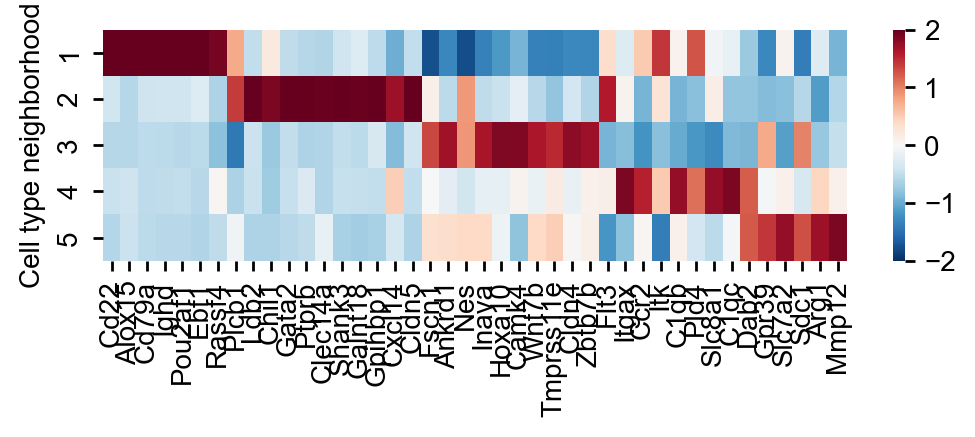

In [129]:
fig, ax = plt.subplots(figsize=(6,1.5)) 
sns.heatmap(expr,cmap = "RdBu_r",vmin = -2,vmax = 2,cbar = True, xticklabels=True,ax= ax, center=0)
plt.ylabel('Cell type neighborhood')
save_plot(fig,'neighborhood_gene_heatmap',plots_path)

In [ ]:
module_scores = []
for section in adata.obs["sample"].unique():
    section_tdata = adata[(adata.obs["sample"] == section)].copy()
    hs = section_tdata.copy()
    hs.X = hs.layers["counts"]
    hs = hs[:,hs.X.sum(axis = 0) > 0].copy()
    section_modules = modules[modules.index.isin(hs.var_names)]
    hs = hotspot.Hotspot(hs,latent_obsm_key="spatial", umi_counts_obs_key="total_counts",model = "normal")
    hs.create_knn_graph(weighted_graph=False, n_neighbors=30)
    hs.modules = section_modules
    module_scores.append(hs.calculate_module_scores())
module_scores = pd.concat(module_scores)
module_scores.columns = module_scores.columns.astype(str)
module = module_scores.idxmax(axis = 1).astype(str)
adata.obs["cell_neighborhood"] = module
adata.obsm["celltype_module_scores"] = module_scores.reindex(adata.obs_names)

In [ ]:
neighborhood_palette = {
    "1":'#8E0496',
    "2":'#CD2626',
    "3":"#1874CD",
    "4":'#009E73',
    "5": '#FFE600',
    "6": '#E69F00'}

In [ ]:
def load_boundaries():
    """Load tumor and module boundaries."""
    tumor_boundaries = []
    for mouse in ["M1","M2","M3"]:
        mouse_boundaries = gpd.read_file(
            data_path / f"{mouse}_tumor_boundaries.json").set_crs(None, allow_override=True)
        mouse_boundaries["tumor"] = mouse + "-T" +  mouse_boundaries["tumor"].astype(str)
        tumor_boundaries.append(mouse_boundaries)
    tumor_boundaries = gpd.GeoDataFrame(pd.concat(tumor_boundaries, ignore_index=True))
    tumor_boundaries["sample"] = tumor_boundaries["sample"].str.replace("-","-S")
    module_boundaries = gpd.read_file(data_path / "M3_module_boundaries.json").set_crs(None, allow_override=True)
    return tumor_boundaries, module_boundaries

In [ ]:
tumor_boundaries, module_boundaries = load_boundaries()

In [103]:
tumor_boundaries[tumor_boundaries['tumor'] == "M1-T4"]

tumor sample                                           geometry
4  M1-T4  M1-S2  LINESTRING (-2581.164 -4357.204, -2581.668 -43...
7  M1-T4  M1-S3  LINESTRING (-3297.708 -4692.848, -3298.212 -46...
9  M1-T4  M1-S4  LINESTRING (-3397.2 -4925.154, -3397.704 -4921...

In [147]:
M1_boundaries_grid = gpd.read_file(data_path / "M1_tumor_boundaries_grid.json").set_crs(None, allow_override=True)
M1_boundaries_grid["tumor"] = "M1" + "-T" +  M1_boundaries_grid["tumor"].astype(str)
M1_boundaries_grid["sample"] = M1_boundaries_grid["sample"].str.replace("-","-S")
M1_boundaries_grid

tumor sample                                           geometry
0  M1-T1  M1-S1  LINESTRING (858.397 3090.079, 857.923 3093.326...
1  M1-T1  M1-S2  LINESTRING (3505.22 3063.006, 3505.213 3065.54...
2  M1-T2  M1-S2  LINESTRING (355.451 4904.086, 354.947 4907.483...
3  M1-T3  M1-S2  LINESTRING (-31.735 7564.844, -32.238 7568.24,...
4  M1-T4  M1-S2  LINESTRING (1003.435 10080.884, 1002.931 10084...
5  M1-T1  M1-S3  LINESTRING (6271.61 2939.969, 6271.106 2943.36...
6  M1-T2  M1-S3  LINESTRING (3413.431 4650.356, 3412.928 4653.7...
7  M1-T4  M1-S3  LINESTRING (3146.413 9745.24, 3145.909 9748.63...
8  M1-T1  M1-S4  LINESTRING (9726.001 2537.536, 9725.497 2540.9...
9  M1-T4  M1-S4  LINESTRING (5906.444 9512.934, 5905.94 9516.33...

In [76]:
np.min(adata[adata.obs["sample"].isin(["M1-2"]) & adata.obs["tumor"].isin(["1"])].obsm['spatial'][:, 1])

array(5.89416716)

/lab/solexa_weissman/kyost/miniconda3/envs/petracer/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/lab/solexa_weissman/kyost/miniconda3/envs/petracer/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


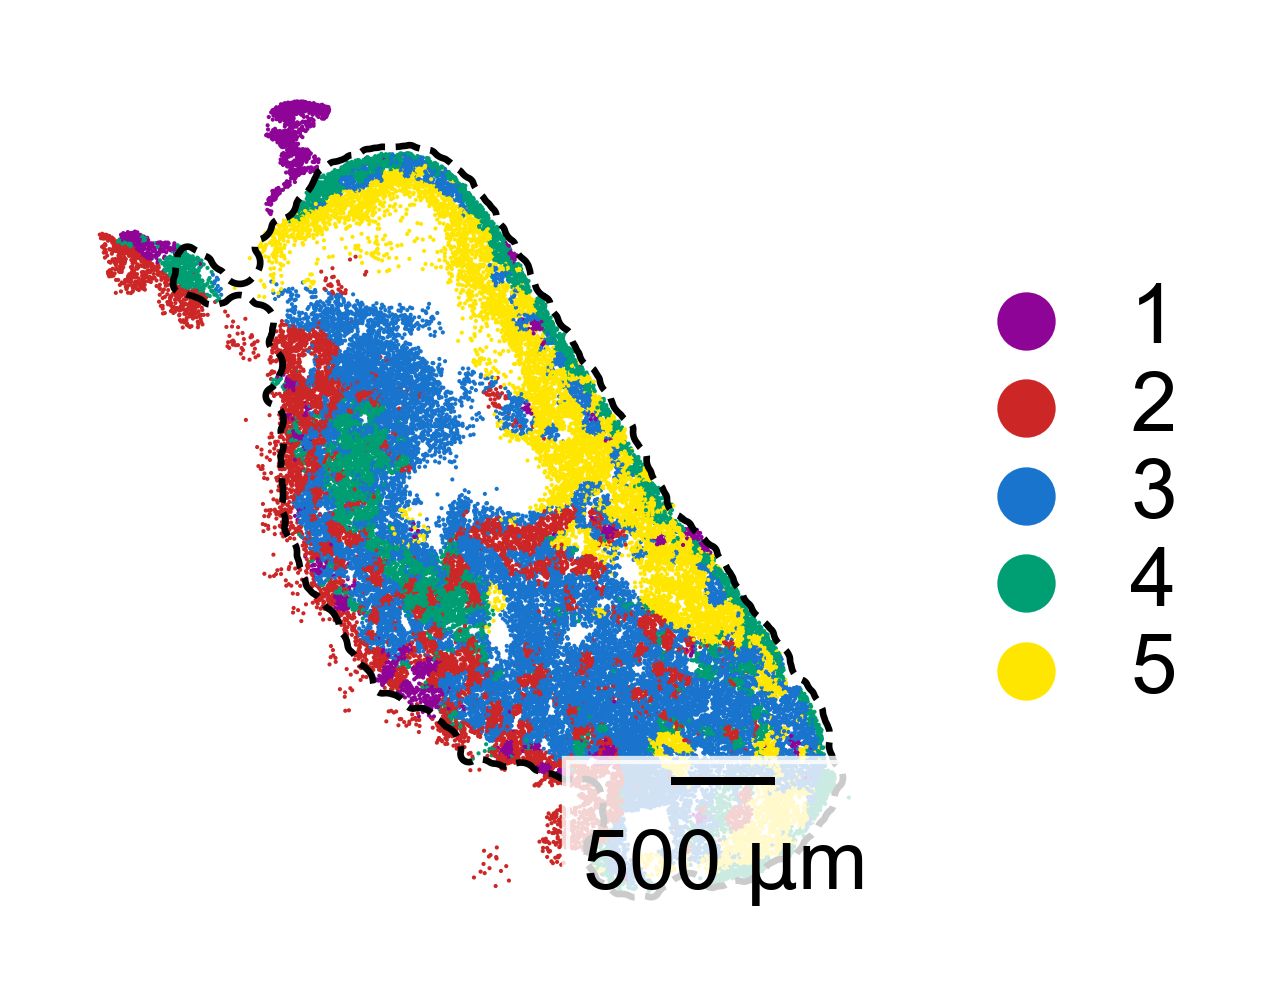

In [79]:
figsize = (2, 2)
fig, ax = plt.subplots(figsize=figsize,dpi = 600, layout = "constrained")
sc.pl.spatial(adata[adata.obs["sample"].isin(["M1-2"]) & adata.obs["tumor"].isin(["1"])]
              ,spot_size=20,color = "cell_neighborhood", basis = "spatial_overlay"
              ,frameon=False,title = "", ax = ax,show = False, palette=neighborhood_palette)
plt.gca().invert_yaxis()
tumor_boundaries[(tumor_boundaries['sample'] == "M1-S2") & (tumor_boundaries['tumor']=="M1-T1")].plot(
    edgecolor = "black",facecolor = "none" ,legend = False,ax = ax,linewidth = .8
    , linestyle = "--")
ax.add_artist(ScaleBar(dx = 1,units="um",location='lower right',
                       color = "black",box_alpha=.8,fixed_value = 500))
save_plot(fig,'M1_S2_T1_neighborhoods',plots_path, rasterize=True, dpi = 1200)

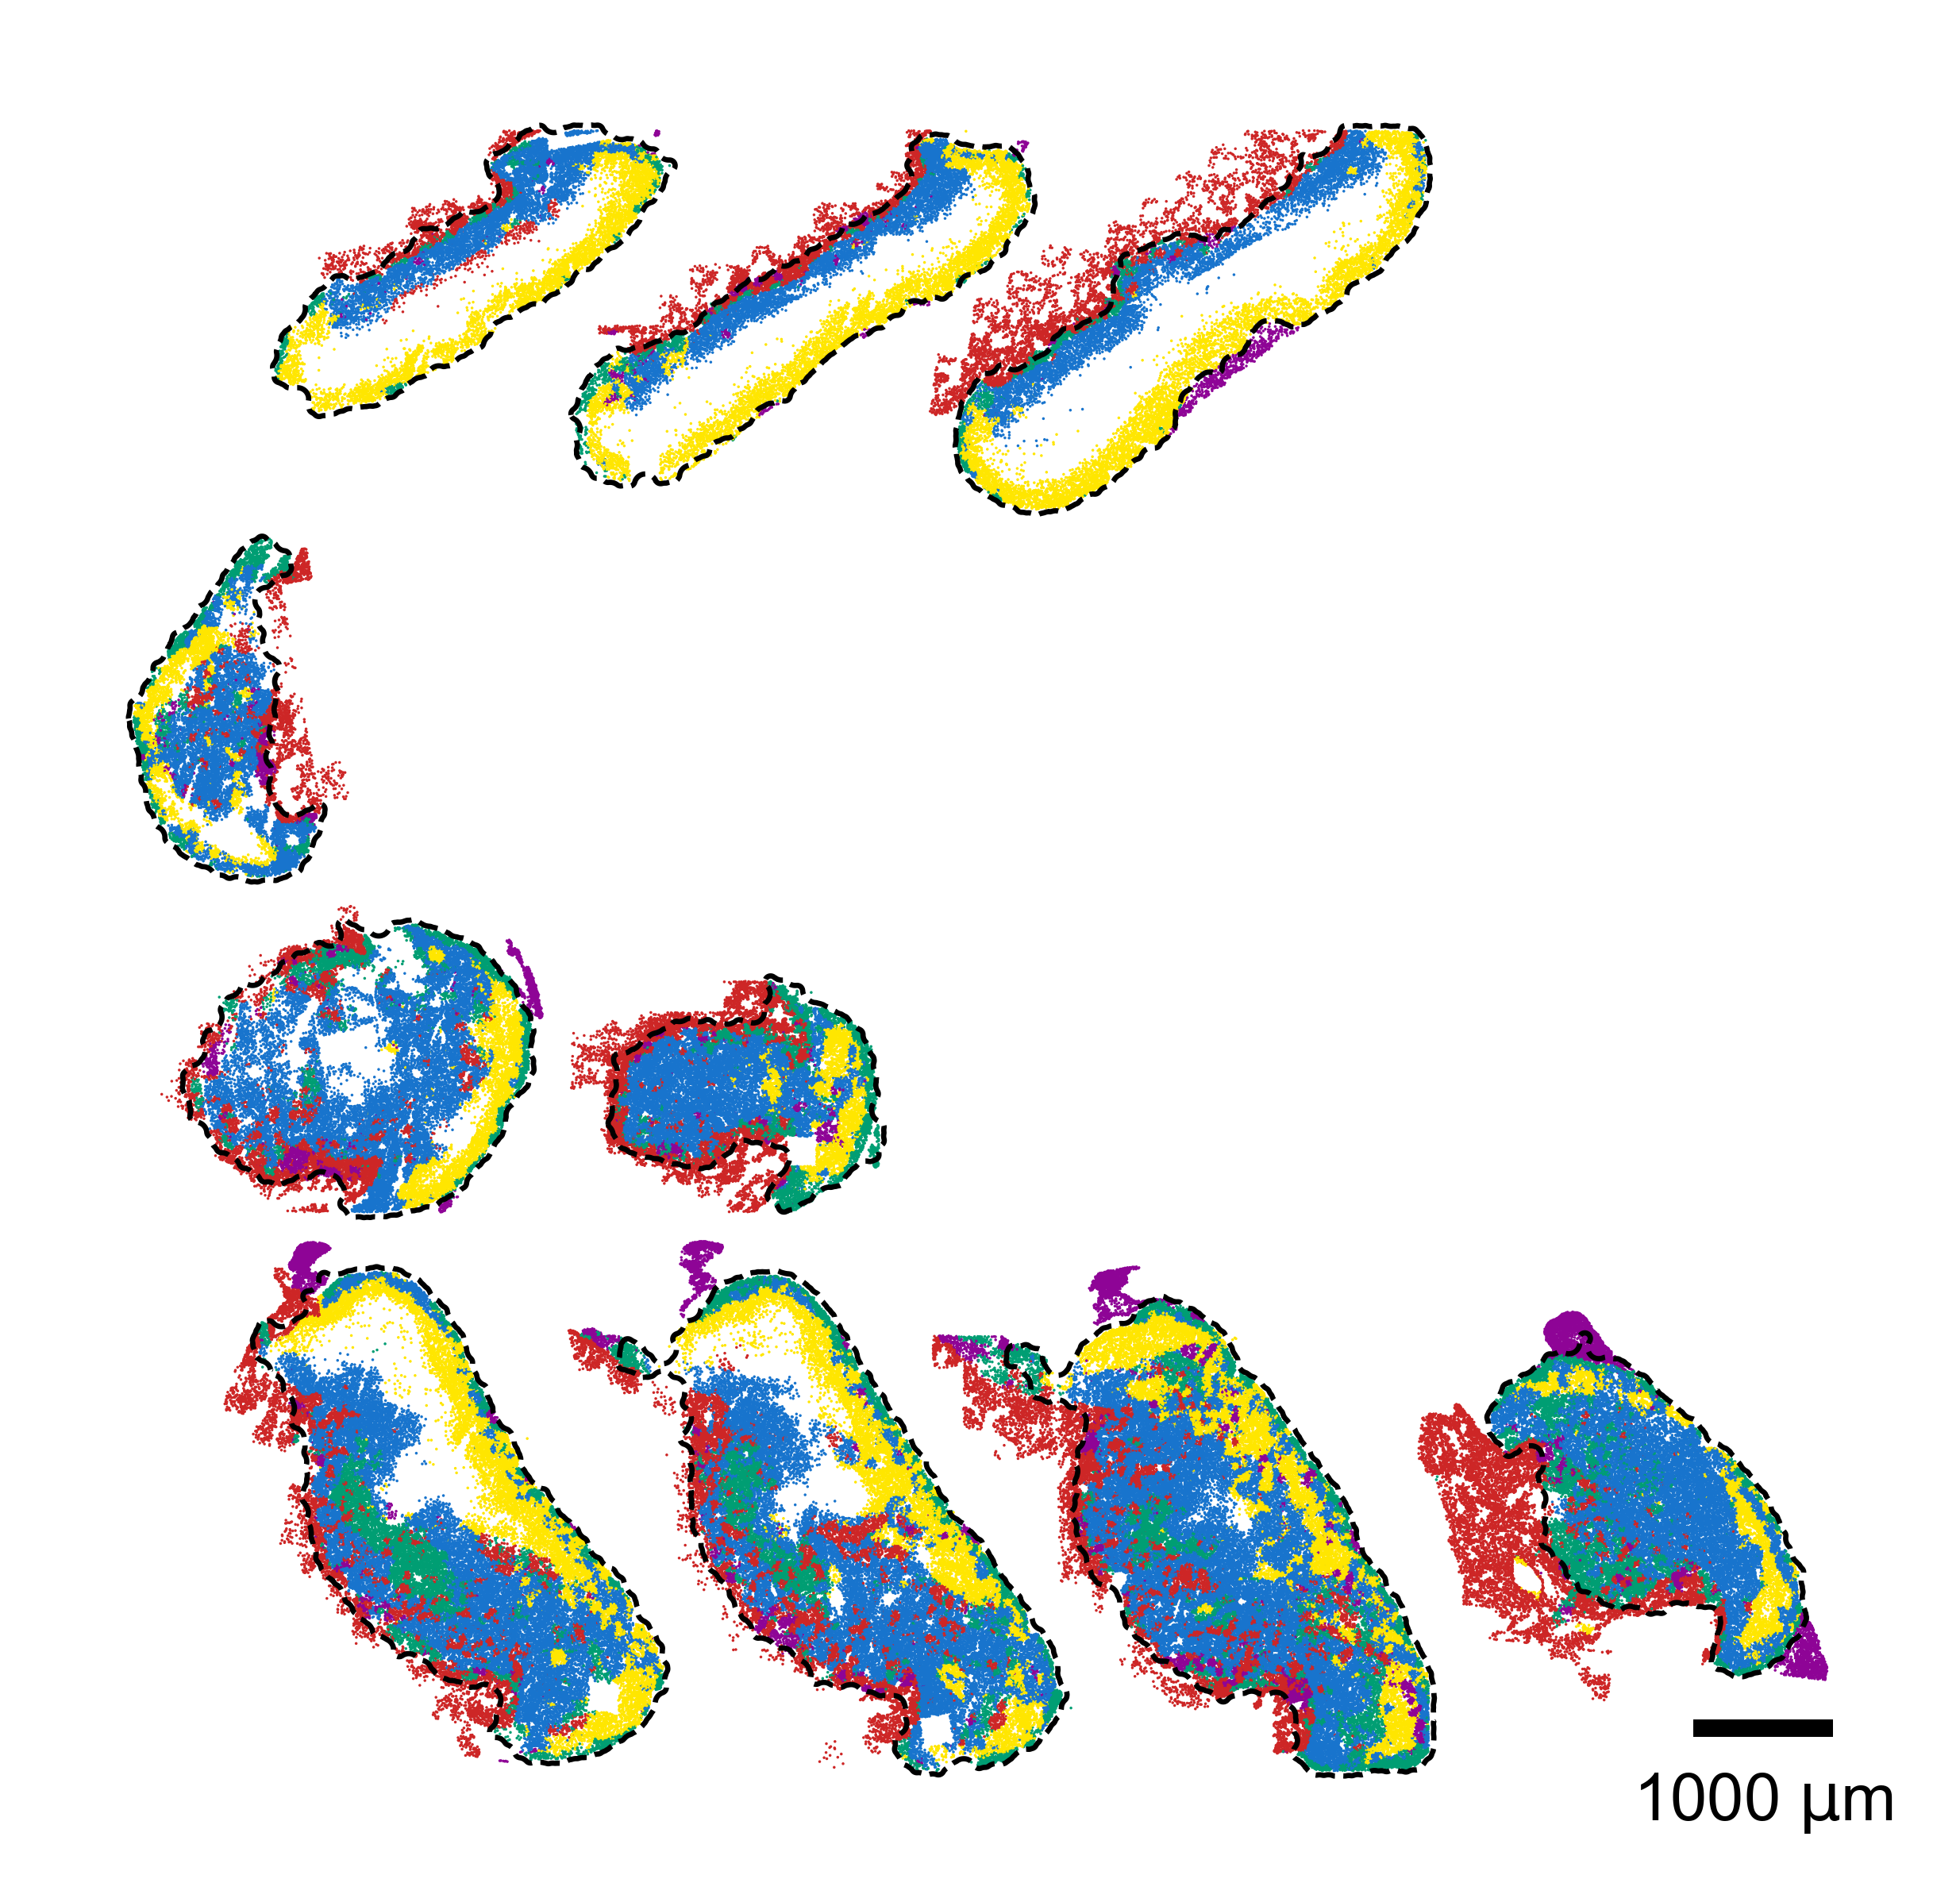

In [149]:
figsize = (4, 4)
fig, ax = plt.subplots(figsize=figsize,dpi = 600, layout = "constrained")
sc.pl.spatial(adata, legend_loc="none"
              ,spot_size=20,color = "cell_neighborhood", basis = "spatial_grid"
              ,frameon=False,title = "", ax = ax,show = False, palette=neighborhood_palette)
plt.gca().invert_yaxis()
M1_boundaries_grid.plot(edgecolor = "black",facecolor = "none" ,legend = False,ax = ax
                        ,linewidth = .8, linestyle = "--")
ax.add_artist(ScaleBar(dx = 1,units="um",location='lower right',
                       color = "black",box_alpha=.8,fixed_value = 1000))
save_plot(fig,'M1_neighborhoods',plots_path, rasterize=True, dpi = 1200)

In [95]:
adata

TreeData object with n_obs × n_vars = 262062 × 124
    obs: 'sample', 'cell', 'cellBC', 'fov', 'centroid_x', 'centroid_y', 'centroid_z', 'n_layers', 'volume', 'n_genes_by_counts', 'total_counts', 'cell_subtype', 'true_proportion', 'diffusion_proportion', 'background_proportion', 'total_density', 'tumor', 'tumor_boundary_dist', 'within_tumor', 'lung_boundary_dist', 'type', 'clone', 'detection_rate', 'tree', 'fitness', 'clade', 'character_dist_of_relatives', 'local_character_diversity', 'cell_neighborhood'
    uns: 'cell_subtype_colors', 'clone_characters', 'within_tumor_colors'
    obsm: 'X_resolVI', 'X_umap', 'characters', 'resolvi_celltypes', 'spatial', 'spatial_grid', 'spatial_overlay', 'subtype_density', 'celltype_module_scores'
    layers: 'counts', 'generated_expression', 'normalized', 'scaled'
    obst: '1', '1_collapsed', '2', '2_collapsed', '3', '3_collapsed', '4', '4_collapsed'

In [80]:
adata_M2 = td.read_h5ad(data_path / "M2_tumor_tracing.h5td")

In [81]:
module_scores = []
for section in adata_M2.obs["sample"].unique():
    section_tdata = adata_M2[(adata_M2.obs["sample"] == section)].copy()
    if len(section_tdata) == 0:
        continue
    hs = section_tdata.copy()
    hs.X = hs.layers["counts"]
    hs = hs[:,hs.X.sum(axis = 0) > 0].copy()
    section_modules = modules[modules.index.isin(hs.var_names)]
    hs = hotspot.Hotspot(hs,latent_obsm_key="spatial", umi_counts_obs_key="total_counts",model = "normal")
    hs.create_knn_graph(weighted_graph=False, n_neighbors=30)
    hs.modules = section_modules
    module_scores.append(hs.calculate_module_scores())
module_scores = pd.concat(module_scores)
module_scores.columns = module_scores.columns.astype(str)
module = module_scores.idxmax(axis = 1).astype(str)
adata_M2.obs["cell_neighborhood"] = module
adata_M2.obsm["celltype_module_scores"] = module_scores.reindex(adata_M2.obs_names)

/lab/solexa_weissman/kyost/miniconda3/envs/petracer/lib/python3.11/site-packages/hotspot/hotspot.py:98: UserWarning: Hotspot will work faster when counts are a csr sparse matrix.
  warnings.warn(


Computing scores for 5 modules...


100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


In [144]:
adata_M2.write(data_path / "M2_tumor_tracing.h5td")

/lab/solexa_weissman/kyost/miniconda3/envs/petracer/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/lab/solexa_weissman/kyost/miniconda3/envs/petracer/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


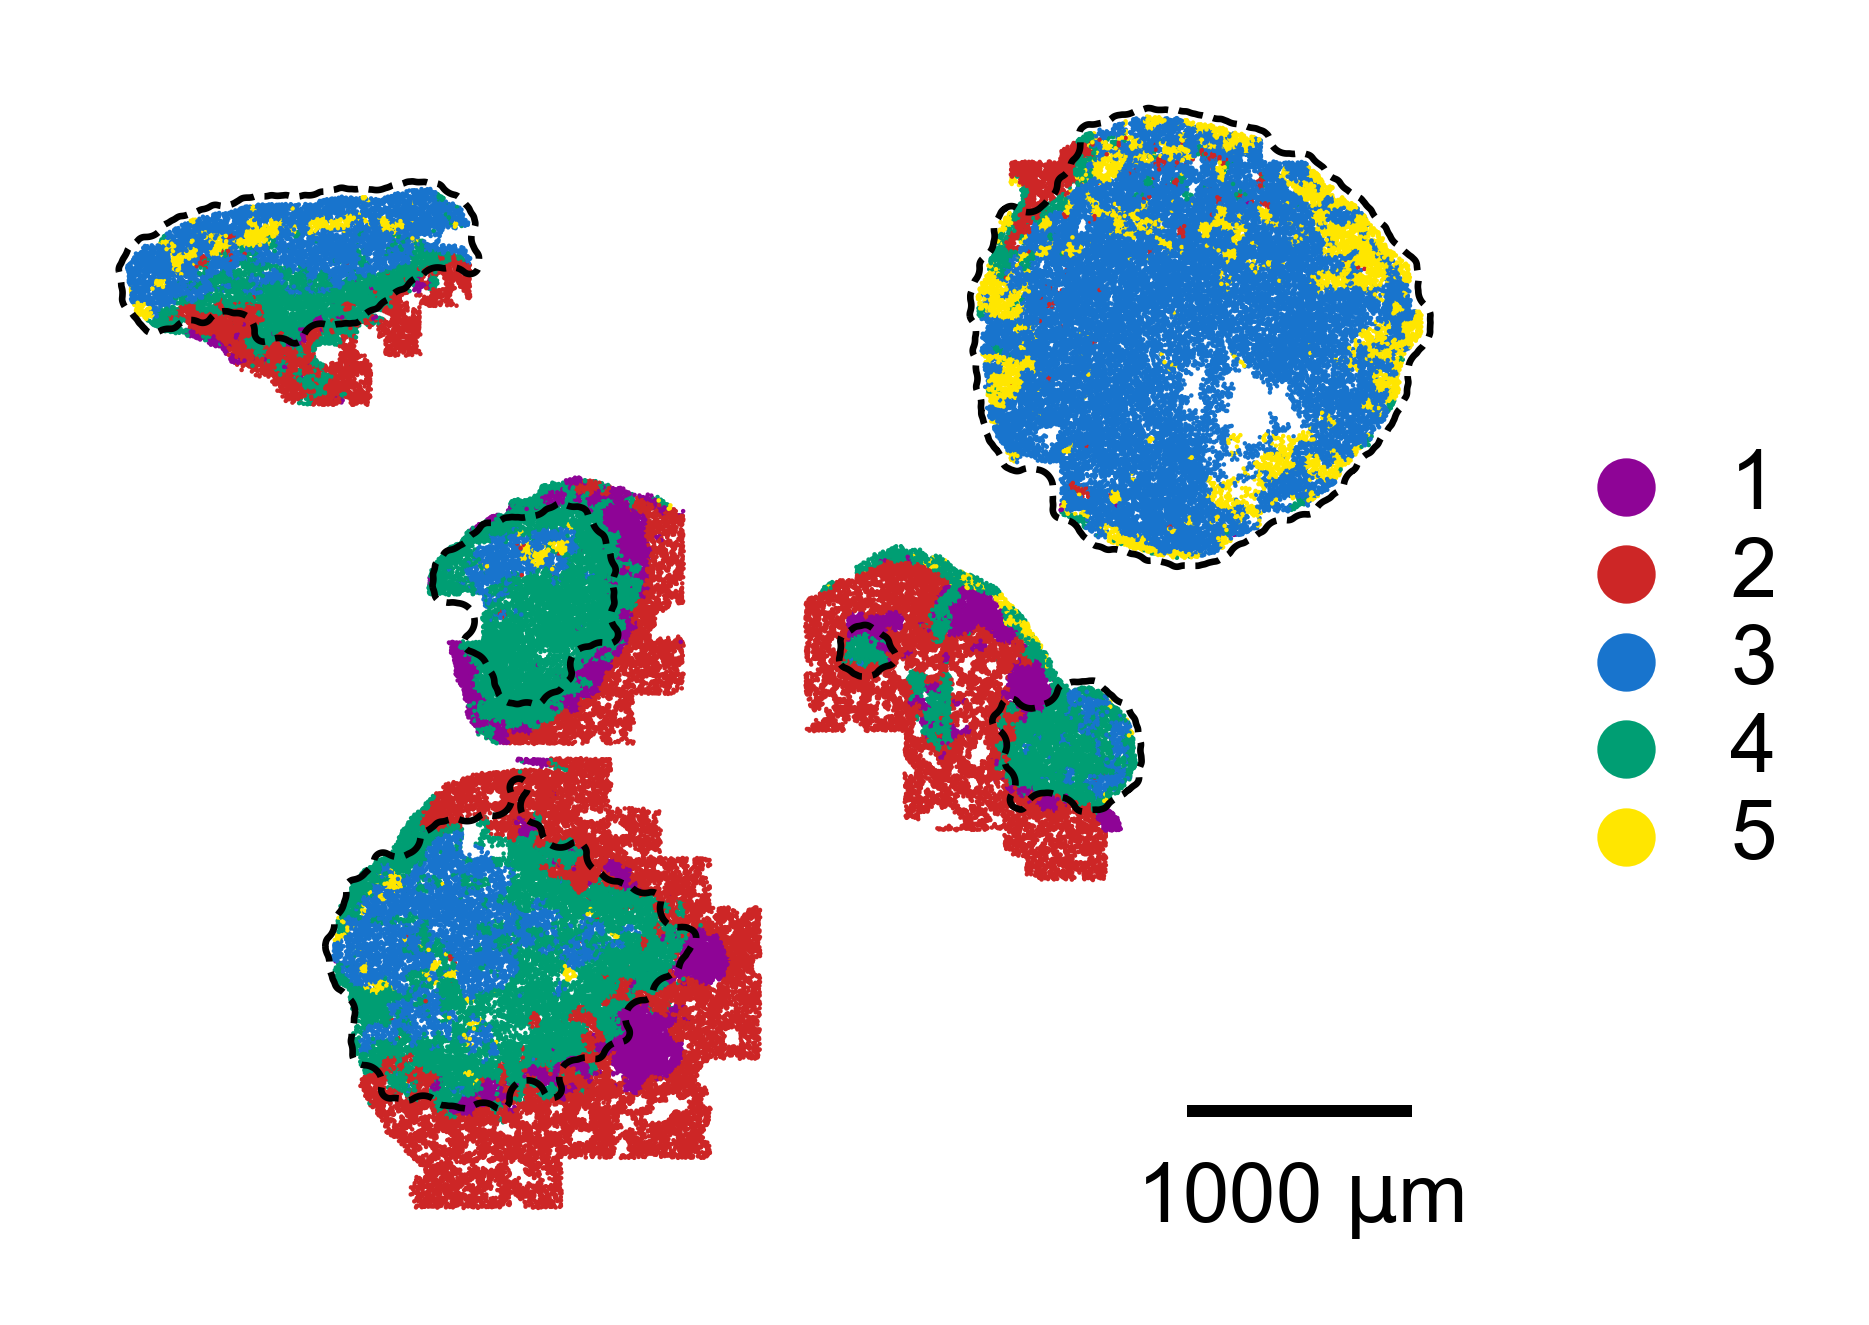

In [90]:
figsize = (3, 3)
fig, ax = plt.subplots(figsize=figsize,dpi = 600, layout = "constrained")
sc.pl.spatial(adata_M2[adata_M2.obs["sample"].isin(["M2-1"])]
              ,spot_size=20,color = "cell_neighborhood", basis = "spatial_overlay"
              ,frameon=False,title = "", ax = ax,show = False, palette=neighborhood_palette)
plt.gca().invert_yaxis()
tumor_boundaries[(tumor_boundaries['sample'] == "M2-S1")].plot(
    edgecolor = "black",facecolor = "none" ,legend = False,ax = ax,linewidth = .8
    , linestyle = "--")
ax.add_artist(ScaleBar(dx = 1,units="um",location='lower right',
                       color = "black",box_alpha=.8,fixed_value = 1000))
save_plot(fig,'M2_S1_neighborhoods',plots_path, rasterize=True, dpi = 1200)

In [87]:
adata_M2.obs['sample'].value_counts()

sample
M2-1    106660
Name: count, dtype: int64

In [82]:
adata_merge = ad.concat([adata, adata_M2], join="inner")

In [83]:
adata_merge = adata_merge[adata_merge.obs["cell_neighborhood"].notnull()].copy()

In [84]:
adata_merge.obsm['subtype_density'].columns

Index(['Malignant', 'ARG1 macrophage', 'CD11c macrophage', 'ALOX15 macrophage',
       'Exhausted CD8 T cell', 'CD4 T cell', 'Treg', 'B cell', 'cDC',
       'Neutrophil', 'NK', 'pDC', 'Endothelial', 'Cancer fibroblast',
       'Alveolar fibroblast 1', 'Alveolar fibroblast 2', 'AT1/AT2',
       'Club cell'],
      dtype='object')

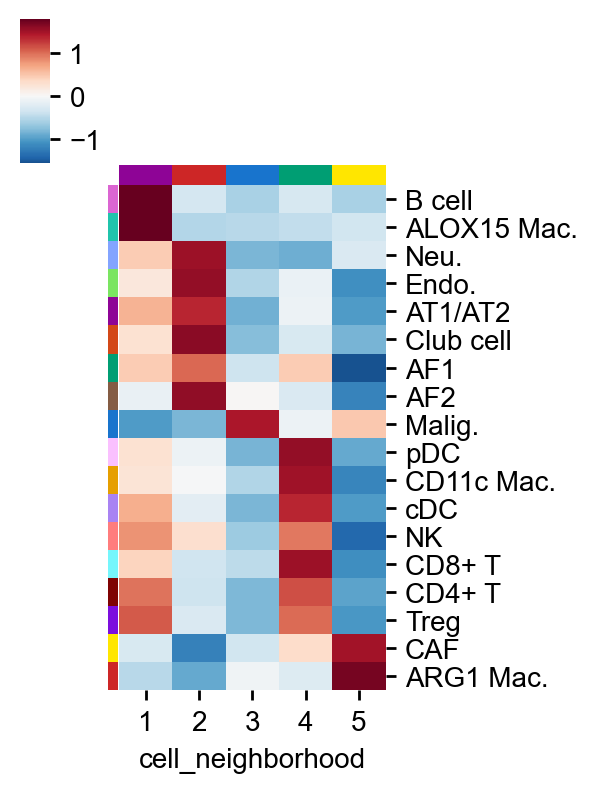

In [85]:
figsize = (3, 4)
from petracer.config import (  # noqa: E402
    colors,
    edit_palette,
    get_clade_palette,
    phase_palette,
    subtype_abbr,
    subtype_palette,
)
df = sc.get.aggregate(adata_merge, by=["cell_neighborhood"], func=["mean"], obsm = 'subtype_density')
df = pd.DataFrame(df.layers['mean'], index =df.obs['cell_neighborhood'], columns=df.var.index)
subtype_order = ['B cell', 'ALOX15 macrophage',
                 'Neutrophil','Endothelial','AT1/AT2','Club cell','Alveolar fibroblast 1','Alveolar fibroblast 2',
                 'Malignant','pDC','CD11c macrophage',
                 'cDC','NK',
                 'Exhausted CD8 T cell', 'CD4 T cell','Treg',
                 'Cancer fibroblast','ARG1 macrophage' ]
df = df.loc[:,subtype_order].transpose()
g = sns.clustermap(df,cmap="RdBu_r", z_score =0, figsize = figsize, row_cluster=False, col_cluster=False,
                   col_colors= [neighborhood_palette[i] for i in df.columns],center = 0,
                   row_colors = [subtype_palette[i] for i in df.index]
                   ,yticklabels = df.index.map(subtype_abbr))
g.ax_heatmap.set(ylabel=None)
save_plot(g,'neighborhood_enrichment',plots_path)

In [ ]:
def load_tdata():
    """Load tumor tracing data."""
    clones = {}
    mice = {}
    use_clones = []
    for mouse in ["M1","M2","M3"]:
        tdata = td.read_h5ad(data_path/ f"{mouse}_tumor_tracing.h5td")
        if mouse == "M3":
            tdata = tdata[tdata.obs["sample"] != "M3-3"].copy()
        tdata.obs["sample"] = tdata.obs["sample"].str.replace("-","-S")
        tdata.obs["mouse"] = mouse
        tdata.obs["tumor"] = tdata.obs["mouse"] + "-T" + tdata.obs["tumor"].astype(str)
        tdata.obs["subtype_abbr"] = pd.Categorical([subtype_abbr[i] for i in tdata.obs["cell_subtype"]])
        mice[mouse] = tdata
    libraries = {"M1M2":ad.concat([mice["M1"],mice["M2"]], join='outer', fill_value=0),
                "M3":mice["M3"]}
    for mouse, mouse_tdata in mice.items():
        for clone in mouse_tdata.obs["clone"].cat.categories:
            tumor = mouse_tdata.obs.query("clone == @clone")['tumor'].value_counts().idxmax()
            clone_tdata = mouse_tdata[mouse_tdata.obs["tumor"] == tumor].copy()
            clone_tdata.obsm["characters"] = clone_tdata.obsm["characters"].loc[:,clone_tdata.uns["clone_characters"][clone]]
            clone_tdata.obst["tree"] = clone_tdata.obst[f"{clone}_collapsed"].copy()
            del clone_tdata.obst[f"{clone}_collapsed"]
            del clone_tdata.obst[f"{clone}"]
            clones[f"{mouse}-T{clone}"] = clone_tdata
            if clone_tdata.obs["fitness"].notnull().any():
                use_clones.append(f"{mouse}-T{clone}")
    return libraries, clones, use_clones

In [ ]:
def subtype_marker_dotplot(plot_name,tdata,gene_subset = None,gene_order = None,subtype_order = None,
                           swap_axes = False,largest_dot = 50,figsize = (3, 2.5)):
    """Plot dotplot of subtype marker genes."""
    # Get gene order based on subtype expression
    if gene_order is None:
        mean_counts = sc.get.aggregate(tdata, by=["subtype_abbr"], func=["mean"], layer = 'counts')
        mean_counts = pd.DataFrame(mean_counts.layers['mean'], index = mean_counts.obs['subtype_abbr'], columns=mean_counts.var.index)
        gene_sort = pd.DataFrame(mean_counts.idxmax(axis=0), columns=['subtype_abbr'])
        gene_sort = pd.merge(gene_sort, pd.DataFrame(mean_counts.max(axis=0), columns=["max_exp"]),left_index=True, right_index= True)
        if gene_subset is not None:
            gene_sort["subset"] = gene_sort.index.isin(gene_subset)
            gene_order = list(gene_sort.sort_values(['subset','subtype_abbr', 'max_exp'], ascending=[True,True, False]).index)
        else:
            gene_order = list(gene_sort.sort_values(['subtype_abbr', 'max_exp'], ascending=[True, False]).index)
    if subtype_order is None:
        subtype_order = list(tdata.obs["subtype_abbr"].cat.categories)
    # Plot
    fig, ax = plt.subplots(1,1, figsize=figsize)
    dp = sc.pl.dotplot(tdata, var_names = gene_order,layer = 'normalized',categories_order = subtype_order,
                    groupby = "subtype_abbr",swap_axes = swap_axes,ax = ax, return_fig = True)
    dp.style(largest_dot = largest_dot, cmap = "Reds")
    dp.legend(show = False)
    dp.show()
    save_plot(fig,plot_name,plots_path,rasterize=False)

In [ ]:
from petracer.config import (  # noqa: E402
    colors,
    edit_palette,
    get_clade_palette,
    module_palette,
    phase_palette,
    subtype_abbr,
    subtype_palette,
)

In [ ]:
libraries, clones, use_clones = load_tdata()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2.5))
genes_reordered = ["Cd22","Alox15","Cxcr2", "Shank3", "Chil1","Cyp4b1","Col5a2","Cxcl14"
                   ,"Ebf1","Wnt7b", 'Siglech', "C1qb","Itgax","Flt3",'Ncr1',"Cd3g","Cd8a"
                   , "Cd4","Foxp3","Gpr39", "Arg1"]
cell_subtype_abbr_reordered = ['B cell','ALOX15 Mac.','Neu.','Endo.','AT1/AT2','Club cell'
                               ,'AF1','AF2','Malig.','pDC','CD11c Mac.','cDC','NK','CD8+ T'
                               ,'CD4+ T','Treg','CAF','ARG1 Mac.']
dp = sc.pl.dotplot(libraries["M1M2"], var_names = genes_reordered
              , categories_order = cell_subtype_abbr_reordered, layer = 'normalized'
               , groupby = "subtype_abbr", ax =ax, return_fig = True, swap_axes = False)
dp.style(largest_dot = 50, cmap = "Reds")
dp.legend(show = False)
dp.savefig("plots/M1M2_subtype_marker_dotplot_v1.pdf")

In [ ]:
dp.savefig

In [ ]:
subtype_marker_dotplot("M1M2_subtype_marker_dotplot_v1",libraries["M1M2"],
                       gene_order= ["Cd22","Alox15","Cxcr2", "Shank3", "Chil1","Cyp4b1","Col5a2","Cxcl14"
                                    ,"Ebf1","Wnt7b", 'Siglech', "C1qb","Itgax","Flt3",'Ncr1',"Cd3g","Cd8a"
                                    , "Cd4","Foxp3","Gpr39", "Arg1"],
                       subtype_order = ['B cell','ALOX15 Mac.','Neu.','Endo.','AT1/AT2','Club cell'
                                        ,'AF1','AF2','Malig.','pDC','CD11c Mac.','cDC','NK','CD8+ T'
                                        ,'CD4+ T','Treg','CAF','ARG1 Mac.'])

In [ ]:
seq_adata = ad.read_h5ad(data_path / "10x_4T1_primary.h5ad")

In [ ]:
df = pd.DataFrame(seq_adata.X.todense())

In [ ]:
len(seq_adata.var_names)

In [ ]:
df.columns = seq_adata.var_names
df.index = seq_adata.obs.index

In [ ]:
corr_mat = df.corrwith(df['Mki67'])

In [ ]:
tdata_M3 = td.read_h5ad(data_path / "M3_tumor_tracing.h5td")

In [ ]:
tdata_M3.var_names

In [ ]:
df_plot = pd.DataFrame(corr_mat[corr_mat.index.isin(cc_genes)].sort_values(ascending = True))
df_plot.columns = ["corr"]
df_plot['assignment'] = "G2/M"
df_plot.loc[df_plot.index.isin(s_genes), 'assignment'] = "S"
df_plot

In [ ]:
plt.barh(df_plot.index,  df_plot['corr'], color=[phase_palette[i] for i in df_plot.assignment])
plt.xlabel('Correlation with Mki67 expression')
labels = list(phase_palette.keys())
plt.legend([plt.Rectangle((0,0),1,1, color=phase_palette[label]) for label in labels], labels)
plt.show()

In [ ]:
fig,ax = plt.subplots(figsize = (4,2), dpi = 600,sharex=True, layout = "constrained")
df_plot.plot(kind="bar",x = 'index',y = 'corr', ax=ax, color='assignment', width=0.8)


In [ ]:
g2m_genes = ["Cdca2", "Kif2c", "Ncapd2", "Nek2"]
s_genes = ["Dscc1", "Msh2", "Rad51", "Rpa2", "Ung"]
cc_genes = g2m_genes+s_genes

In [ ]:
cc_genes

In [ ]:
tdata_M3.obs['cell_subtype_module'] = tdata_M3.obs['cell_subtype'].astype(str)
tdata_M3.obs['cell_subtype_module'][
    tdata_M3.obs['cell_subtype'] == "Malignant"] = tdata_M3.obs['cell_subtype_module'][
    tdata_M3.obs['cell_subtype'] == "Malignant"].astype(str) + "_" + tdata_M3.obs['hotspot_module'][
    tdata_M3.obs['cell_subtype']== "Malignant"].astype(str)

In [ ]:
phase_counts = tdata_M3.obs.groupby(['cell_subtype_module','phase'], observed = True).size().unstack().fillna(0)
phase_counts = phase_counts.div(phase_counts.sum(axis = 1),axis = 0)*100
phase_counts = phase_counts.loc[:,["G2/M","S","G0/G1"]]
col_order = list(phase_counts['G0/G1'].sort_values().index)
col_order = [i for i in col_order if "Malignant" not in i]
col_order = ["Malignant_1", "Malignant_2", "Malignant_3","Malignant_4"] + col_order
phase_counts.index = pd.Categorical(phase_counts.index
                                    , categories=col_order
                                    , ordered=True)
phase_counts = phase_counts.sort_index()

In [ ]:
fig,ax = plt.subplots(figsize = (4,2), dpi = 600,sharex=True, layout = "constrained")
phase_counts.plot(kind="bar", stacked=True, ax=ax, color=[phase_palette[phase] for phase in 
                                                          phase_counts.columns]
                  , width=0.8)
plt.ylabel("Phase (%)")
ax.set_xticklabels([subtype_abbr[i] if i in subtype_abbr.keys() else i for i in phase_counts.index])
plt.xlabel("")
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.05))
save_plot(fig,"cell_cycle_subtype",plots_path)

In [ ]:
tdata_M3.obs['cell_class_module'] = tdata_M3.obs['cell_subtype_module']
tdata_M3.obs['cell_class_module'][tdata_M3.obs['cell_class_module'].isin(
    ['Neutrophil', 'NK', 'B cell', 'Exhausted CD8 T cell', 'Treg', 'CD11c macrophage',
     'cDC', 'Alveolar macrophage', 'ARG1 macrophage', 'Tumor endothelial','Cancer fibroblast', 
     'Alveolar fibroblast 2', 'Alveolar fibroblast 1'])] = "Other"
tdata_M3.obs['cell_class_module'][tdata_M3.obs['cell_class_module'].isin(
    ['AT1/AT2', 'CAP2 endothelial', 'CAP1 endothelial', 'Club cell'])] = "Stromal"
tdata_M3.obs['cell_class_module'].unique()

In [ ]:
phase_counts = tdata_M3.obs.groupby(['cell_class_module','phase'], observed = True).size().unstack().fillna(0)
phase_counts = phase_counts.div(phase_counts.sum(axis = 1),axis = 0)*100
phase_counts = phase_counts.loc[:,["G2/M","S","G0/G1"]]
col_order = ["Malignant_1", "Malignant_2", "Malignant_3","Malignant_4", "Other", "Stromal"][::-1]
phase_counts.index = pd.Categorical(phase_counts.index
                                    , categories=col_order
                                    , ordered=True)
phase_counts = phase_counts.sort_index()
phase_counts = phase_counts[phase_counts.index != "Other"]

In [ ]:
fig,ax = plt.subplots(figsize = (2,1.5), dpi = 600,sharex=True, layout = "constrained")
phase_counts.plot(kind="barh", stacked=True, ax=ax, color=[phase_palette[phase] for phase in 
                                                          phase_counts.columns]
                  , width=0.8, legend=None)
plt.xlabel("Phase (%)")
ax.set_yticklabels([subtype_abbr[i] if i in subtype_abbr.keys() else i for i in phase_counts.index])
plt.ylabel("")
#plt.legend(loc='upper right', bbox_to_anchor=(1.8, 1.05))
save_plot(fig,"cell_cycle_broad_celltype",plots_path)